# Bayesian Optimization

## Installation & Imports

In [1]:
try:
    import bayes_nanospace2025
    print("Already installed")
except ImportError:
    %pip install -q "bayes_nanospace2025 @ git+https://github.com/Mads-PeterVC/nanospace2025.git" # Install from GitHub. 
    print("Installed bayes_nanospace2025 from GitHub")

Already installed


<div class="alert alert-block alert-danger"> <b>Warning:</b> If packages weren't already installed, please refresh this page in your <b> browser</b>, you shouldn't need to restart the Jupyter kernel, as otherwise the widgets used won't show properly. Sorry for the inconvenience! </div>

In [2]:
import numpy as np
from bayes_nanospace2025 import GaussianProcess, RadialBasis, Noise, Constant, YourCodeHere
from bayes_nanospace2025.tutorial.gp import PredictionResult
from bayes_nanospace2025.tutorial.test_functions import himmelblau
from bayes_nanospace2025.tutorial import plot_bo, plot_bo_2d
from typing import Callable

## Bayesian Optimization with GPs.

With Bayesian optimization (BO) we wish to optimize some, possibly blackbox, function that is 
typically quite expensive to evaluate such as computationally heavy calculations, e.g. DFT, or laboratory experiments. 

Formally, we say that we are looking for 

$$
x_{\mathrm{opt}} = \mathrm{argmin}_{x \in D} f(x)
$$

Wikipedia describes Bayesian optimization like so; 
> "Since the objective function is unknown, the Bayesian strategy is to treat it as a random function and **place a prior over it**. The prior captures beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the **posterior distribution** over the objective function. The posterior distribution, in turn, is used to construct an **acquisition function** that determines the next query point".

We've already seen how GPs describe a distribution over functions with the prior defined by the covariance function (i.e. kernel) and we've seen how to condition the distribution to 
obtain a posterior distribution where the functions match our observations. The part we haven't seen so far is the use of an **acquisiton function**. A rough outline of the BO algorithm we will develop is as follows;

---

Initialize

- Create a GP model over the domain of interest $D$. 

And then repeats these steps for a number of iterations

1. Evaluate an acquistion function at points in the domain, the acquisition function is based on the GP. 
2. Choose the next observation according to the acquisition function ($\mathrm{argmin}$ or $\mathrm{argmax}$ depending on definition).
3. Evaluate the objective function at "acquired"-coordinate $x_{\mathrm{acq}}$ to get $y_{\mathrm{acq}}$.
4. Add the new observation to our set of observations $(X, y)$
5. Update the GP with new observations.

---

An example of an acquisiton function is the lower confidence bound

$$
\mathrm{LCB}(x) = \mu(x) - \kappa \sigma(x)
$$

Where $\mu(x)$ is the predicted value and $\sigma(x)$ is the predicted standard deviation 'uncertainty' and $\kappa$ is a weighting factor between the two terms. 
This acquisition function will thus have minimas either at locations where the mean is low or where there's a large uncertainty. 

### Bayesian Optimization for a 1D function.

Well start by implementing BO for a 1D function, so we can easily visualize how it progresses. 

First we'll choose some settings and setup some lists for storing results.

In [3]:
# Define the GP
kernel = Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001)
gp = GaussianProcess(kernel=kernel)

objective_function = himmelblau  # Define the objective function

# Settings:
n_iterations = 25
kappa = 2
X_query = np.linspace(-5.0, 5.0, 200).reshape(-1, 1)  # Query points for predictions

# Lists for observations
X_obs = []
y_obs = []
predictions = []
acquisition_functions = []
acquisition_indices = []

Now we're ready to write our optimization loop. In the cell below you need to fill in the following; 

1. Making predictions with the GP. 
2. Calculating the lower-confidence bound acquisition function.
3. Determine the index of the next query point to evaluate with the objective function. 

In [4]:
for iteration in range(n_iterations):
    # Make predictions with the GP
    prediction = gp.predict(X_query)  # YCH: Make predictions with the GP, using the predict method.
    predictions.append(prediction)

    # Construct the LCB acquisition function
    # Remember that the 'prediction' object contains 'prediction.mean' and 'prediction.variance' -> std = sqrt(variance)
    lcb = prediction.mean - kappa * np.sqrt(prediction.variance) # YCH: Implement the LCB
    acquisition_functions.append(lcb)

    # Find the next point to sample (the minimum of the LCB)
    # Use np.argmin to find the index of the minimum value in lcb
    if len(X_obs) > 0:
        index = np.argmin(lcb) # YCH: Determine the index corresponding to the lowest LCB value.
    else: # If no observations pick a random index.
        index = np.random.randint(low=0, high=X_query.shape[0])

    next_x = X_query[index]

    # Evaluate the function at the next point
    next_y = objective_function(next_x.reshape(1, -1))

    # Add new observation to the lists
    X_obs.append(next_x)
    y_obs.append(next_y)
    acquisition_indices.append(index)

    # Update the GP with the new observations
    gp.set_prior_mean(np.mean(y_obs)) # Sets the prior mean of the GP to the mean of the observed values.

    X_obs_arr = np.array(X_obs).reshape(-1, 1)
    y_obs_arr = np.array(y_obs).reshape(-1, 1)
    gp.condition(X_obs_arr, y_obs_arr)  # Update the GP with the new observations


In [5]:
X_plot = X_query.flatten()
truth = himmelblau(X_query).flatten()
plot_bo(predictions=predictions, X_obs=X_obs, y_obs=y_obs, 
                      acquisition_values=acquisition_functions, acquisition_indices=acquisition_indices, 
                      X_plot=X_plot, truth=truth)

### Bayesian Optimizer class

Now we've seen the concept of Bayesian Optimization with GPs in action we can wrap it up 
in a little class to avoid having to repeat code over and over. 

To get some flexibility we will first define an `AcquisitionFunction`-class that, unsurprisingly
defines the acquisition function.

In [6]:
class AcquisitionFunction:
    def __init__(self):
        pass

    def compute(self, prediction: PredictionResult, gp: GaussianProcess, X_query: np.ndarray) -> tuple[int, np.ndarray]:
        """
        Returns the index of the next point to sample and the acquisition function values over the query points.
        """
        raise NotImplementedError("This method should be implemented by subclasses")

We can then implement the lower-confidence bound in this class.

In [7]:
class LowerConfidenceBound(AcquisitionFunction):
    def __init__(self, kappa: float = 2.0):
        super().__init__()
        self.kappa = kappa

    def compute(self, prediction: PredictionResult, gp: GaussianProcess, X_query: np.ndarray) -> tuple[int, np.ndarray]:
        """
        Compute the Lower Confidence Bound (LCB) acquisition function.
        """
        lcb = prediction.mean - self.kappa * np.sqrt(prediction.variance)  # YCH: Construct the LCB acquisition function

        if np.var(lcb) == 0: # If the variance is zero all values are the same, so we pick a random index.
            next_index = np.random.randint(low=0, high=X_query.shape[0])
        else:
            next_index = np.argmin(lcb)  # YCH: Find the index of the minimum value in lcb
        return next_index, lcb

Like with our GP I find it useful to have a data class to carry our results, I've 
created a minimal one below

In [8]:
from dataclasses import dataclass, field

@dataclass
class OptimizationResult:
    X_obs: list = field(default_factory=list)  # List of observed input points
    y_obs: list = field(default_factory=list)  # List of observed output values
    predictions: list[np.ndarray] = field(default_factory=list)  # List of predictions made by the GP
    acquisition_values: list[np.ndarray] = field(default_factory=list)  # List of acquisition function values
    acquisition_indices: list[int] = field(default_factory=list) # List of acquisition indices

    def update(
        self, X_new: np.ndarray, y_new: np.ndarray, prediction: np.ndarray, acq_values: np.ndarray, acq_index: int
    ):
        """
        Update the optimization result with new observations.
        """
        self.X_obs.append(X_new)
        self.y_obs.append(y_new)
        self.predictions.append(prediction)
        self.acquisition_values.append(acq_values)
        self.acquisition_indices.append(acq_index)


Now we can wrap things up - like always there are many ways of going about it. 

I've laid out one option below with the following methods;

- `iterate`: Run an iteration of the BO, making GP predictions and evaluating the acquisition function.
- `query_objective`: Query the objective function.
- `update_gp`: Update the GP with new data.
- `optimize`: Main method.

You will need to fill in the code for these things; 

1. Making predictions with the GP in the `iterate`-method.
2. Using the acquisition function instance to (`self.acquisition_function`) to compute the acquisition function, again in `iterate`
3. Fill in the code in the `optimize`-method.

In [9]:
class BayesianOptimizer:
    def __init__(
        self,
        objective_function: Callable,
        gp: GaussianProcess,
        acquisition_function: AcquisitionFunction,
        objective_input_index: bool = False,
    ):
        self.objective_function = objective_function
        self.gp = gp
        self.acquisition_function = acquisition_function
        self.objective_input_index = objective_input_index

    def iterate(self, X_query):
        # Make predictions with the GP
        prediction = self.gp.predict(X_query)  # YCH: Make predictions with the GP

        # Compute the acquisition function
        acq_index, acq_values = self.acquisition_function.compute(prediction, self.gp, X_query)  # YCH: Compute the acquisition function, by calling the method on the acquisition function instance

        # Find the next point to sample
        next_x, next_y = self.query_objective(X_query, acq_index)

        return next_x, next_y, prediction, acq_values, acq_index

    def query_objective(self, X_query, acq_index):
        next_x = X_query[acq_index]
        if not self.objective_input_index:
            next_y = self.objective_function(next_x.reshape(1, -1))
        else: # If the objective function expects an index, we pass the index directly.
            # This is just to make life easier later, don't worry about it.
            next_y = self.objective_function(acq_index)
        return next_x, next_y

    def update_gp(self, results: OptimizationResult):
        """
        Update the Gaussian Process with new observations.
        """
        y_obs_arr = np.array(results.y_obs).reshape(-1, 1)  # Ensure y_obs is a 2D array
        X_obs_arr = np.atleast_2d(np.array(results.X_obs))

        self.gp.set_prior_mean(np.mean(y_obs_arr))
        self.gp.condition(X_obs_arr, y_obs_arr)

    def optimize(self, X_query: np.ndarray, n_iterations: int):
        results = OptimizationResult()

        for _ in range(n_iterations):
            # Call the iterate method.
            next_x, next_y, prediction, acq_values, acq_index = self.iterate(X_query)  # YCH: Run an iteration of the BO

            # Update our results with new observations
            results.update(next_x, next_y, prediction, acq_values, acq_index)

            # Update the GP with new data
            self.update_gp(results)

        return results

Now we can try our class on the Himmelblau function and confirm that it works

In [10]:
optimizer = BayesianOptimizer(
    objective_function=himmelblau,
    gp=GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001)),
    acquisition_function=LowerConfidenceBound(kappa=2.0),
)

X_query = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)  # Query points for predictions
result = optimizer.optimize(X_query, n_iterations=10)

In [11]:
truth = himmelblau(X_query).flatten()
plot_bo(result, X_plot=X_query.flatten(), truth=truth)

#### Thompson sampling acquisition function

We can now try changing our acquisition function, a particularly interesting one is Thompson sampling, 
where rather than calculating some function of the mean and variance we simply draw a sample from the GP. 
The next query point selected to evaluate with the objective function is then the minimum of that sample. 

So to implement Thompson sampling just two steps are required: 

1. Draw a sample from the GP-model (`gp.sample`)
2. Find the index of the minimum of this sample.

In [12]:
class ThompsonSampling(AcquisitionFunction):
    
    def compute(self, prediction: PredictionResult, gp: GaussianProcess, X_query: np.ndarray) -> tuple[int, np.ndarray]:
        """
        Compute the Thompson sampling acquisition function.
        """
        sample = gp.sample(X_query, n_samples=1).T  # YCH: Sample from the GP with the .sample method.
        next_index = np.argmin(sample) # YCH: Find the index of the minimum value in the sampled function
        return next_index, sample.flatten()

In [13]:
optimizer = BayesianOptimizer(
    objective_function=himmelblau,
    gp=GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001)),
    acquisition_function=ThompsonSampling()
)

X_query = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)  # Query points for predictions
result = optimizer.optimize(X_query, n_iterations=10)

In [14]:
truth = himmelblau(X_query).flatten()
plot_bo(result, X_plot=X_query.flatten(), truth=truth)

#### 2D Bayesian Optimization

We can also try it for a 2D problem

Play around with the settings below and compare with Wikipedia's article on [Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function).

In [15]:
x = np.linspace(-5, 5, 25)
X1, X2 = np.meshgrid(x, x)
X_query = np.vstack([X1.ravel(), X2.ravel()]).T

acquisition_function = ThompsonSampling()  # YCH: Define the acquisition function. Try both LCB & ThompsonSampling
gp = GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=1) + Noise(0.001))

optimizer = BayesianOptimizer(objective_function=himmelblau, gp=gp, acquisition_function=acquisition_function)
result = optimizer.optimize(X_query, n_iterations=50)

In [16]:
plot_bo_2d(result, X1=X1, X2=X2)

## Bayesian Optimization for Atomistic Systems

To illustrate Bayesian optimization for atomistic systems we will investigate 
the energy landscape of a small metal cluster. The cell below uses the `ngl`-widget 
of ASE to display the cluster, you can use the slider to see the configurations.

In [17]:
from bayes_nanospace2025.tutorial.atoms_dataset import get_atoms_data
from ase.visualize import view

atoms_data = get_atoms_data()

view(atoms_data, viewer="ngl")

/Users/au616397/Repositories/bayes_nanospace2025/.venv/lib/python3.12/site-packages/nglview/__init__.py:12: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



The objective function is the potential energy, we will use an effective-medium-theory (EMT) calculator, 
but this could be replaced with a more sophisticated potential, such as DFT.

In [18]:
from ase.calculators.emt import EMT

def objective_function(index):
    if isinstance(index, np.ndarray):
        index = index.flatten()[0]

    atoms = atoms_data[index]
    atoms.calc = EMT()  # Set the calculator
    energy = atoms.get_potential_energy()  # Calculate the potential energy
    return energy  # Return the energy as the objective function value

In [19]:
objective_function(np.array([[0]]))  # Example usage of the objective function

9.735118363665656

In [20]:
X_query = np.arange(len(atoms_data)).reshape(-1, 1)  # Query points for predictions
acquisition_function = LowerConfidenceBound(kappa=2.0)  # Define the acquisition function
gp = GaussianProcess(kernel=Constant(1.0) * RadialBasis(length_scale=10) + Noise(0.0001), prior_mean=10)

optimizer = BayesianOptimizer(objective_function=objective_function, gp=gp, acquisition_function=acquisition_function)

result = optimizer.optimize(X_query, n_iterations=25)

In [21]:
truth = np.array([objective_function(i) for i in range(len(atoms_data))])  # Calculate the true values for the atoms
X_plot = np.arange(len(atoms_data))  # X values for plotting

plot_bo(result, X_plot=X_plot, truth=truth)  # Call the function to plot the Bayesian optimization results

<div class="alert alert-block alert-success"> <b>Takeaway:</b> The GP posterior mean doesn't generalize, notice for example that an observation at around index 40 does not influence the prediction at index 80 or vice versa - even though these are symmetric configurations. </div>

### Descriptors for atomistic systems.


This is rather unimpressive! A large part of the reason is that the coordinates, our features, we use are not 
particularly useful for atomic systems, recall that we want something that has these invariances: 

- **Permutational**: Swapping of atoms of the same species should not change the feature.
- **Translational**: A rigid translation should not change the feature. 
- **Rotational**: A rotation should not change the feature. 

The features we use are just the index of the atoms in the list, and they have none of these properties. 
A relatively simple descriptor that includes all of these properties is the eigenvalue spectrum of the Coulomb matrix, from this, now kind of old, paper [Fast and Accurate Modeling of Molecular Atomization Energies with Machine Learning](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.058301). 
Here the Coulomb-matrix is defined as

$$
\begin{equation}
C_{ij} =
\begin{cases}
    & \frac{Z_i Z_j}{r_{ij}}, \quad i \neq j \\
    & 0.5 Z_i^2, \quad i = j
\end{cases}
\end{equation}
$$

The matrix itself has rotational and translational invariance and by using the sorted eigenvalue spectrum permutational 
invariance is obtained.

In [87]:
def calculate_coulomb_matrix(atoms, return_matrix=False):
    d_mat = atoms.get_all_distances() + np.eye(len(atoms)) * 10  # n_atoms x n_atoms matrix.
    species = atoms.get_atomic_numbers().reshape(-1, 1)  # Get atomic numbers of the atoms
    species_mat = species @ species.T  # Outer product to create a matrix of atomic numbers

    c_matrix = species_mat / d_mat  # YCH: Compute the Coulomb matrix using species_mat and d_mat.
    c_matrix[np.diag_indices_from(c_matrix)] = 0.5 * species.flatten() ** 2

    eigenvalues = np.linalg.eigvalsh(c_matrix)  # Calculate the eigenvalues of the Coulomb matrix
    if return_matrix:
        return eigenvalues, c_matrix
    return eigenvalues

We can check that this works as we would like by plotting it

In [88]:
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt

In [91]:
from ase.build import molecule

def get_benzene_molecule(rotation=None, translation=None, permutation=None, rattle=None):
    atoms = molecule('C6H6')
    atoms.cell = np.eye(3) * 10
    atoms.center()

    if rotation is not None:
        atoms.rotate(rotation, v=(0, 0, 1), center='COM', rotate_cell=False)
    if translation is not None:
        atoms.translate(translation)
    if permutation is not None:
        atoms = atoms[permutation]
    if rattle is not None:
        atoms.rattle(rattle, seed=42)

    return atoms

def plot_atoms_descriptor(axes, atoms):

    # PLot the atoms in the first axes
    plot_atoms(atoms, ax=axes[0])
    axes[0].axis('off')

    # Calculate the Coulomb matrix and its eigenvalues
    eigenvalues, c_matrix = calculate_coulomb_matrix(atoms, return_matrix=True)

    base_line = get_benzene_molecule()
    eigenvalues_base, _ = calculate_coulomb_matrix(base_line, return_matrix=True)

    # Plot the Coulomb matrix in the second axes
    im = axes[1].imshow(c_matrix, cmap='viridis', interpolation='nearest')
    axes[1].axis('off')

    # Plot the eigenvalues in the third axes
    axes[2].bar(range(len(eigenvalues)), eigenvalues, facecolor='mediumpurple', edgecolor='black')

    mse = np.mean((eigenvalues - eigenvalues_base) ** 2)
    axes[2].text(0.5, 0.95, f'MSE: {mse:.2f}', transform=axes[2].transAxes, ha='center', va='top')

    #axes[2].set_title('Eigenvalues of Coulomb Matrix')

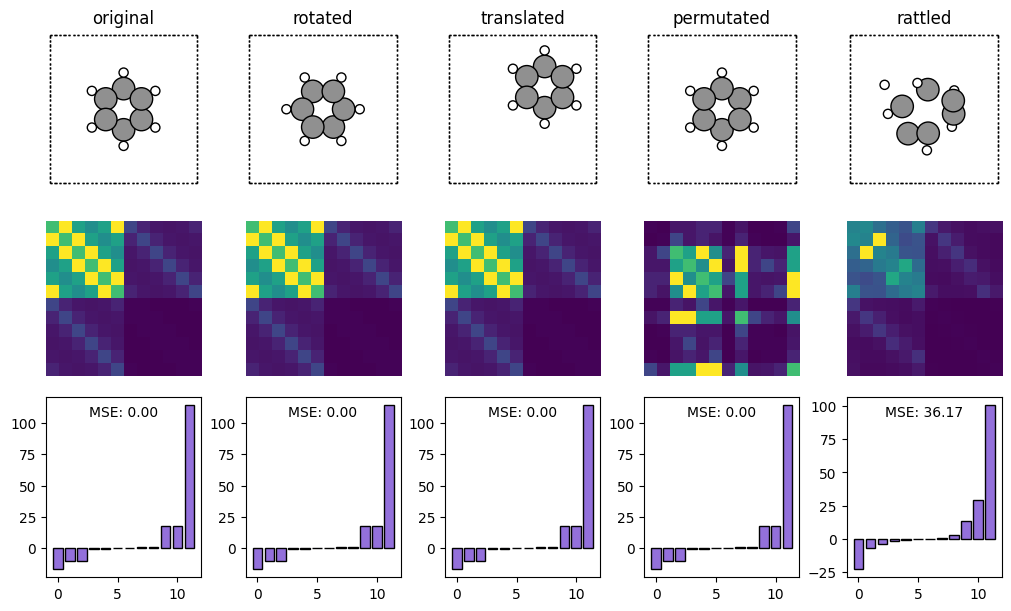

In [92]:
pertubations = {
    'original': {},
    'rotated': {'rotation': 30},
    'translated': {'translation': [1.5, 1.5, 0]},
    'permutated': {
        'permutation': np.random.permutation(np.arange(12))
    },
    'rattled': {'rattle': 0.5}
}

sz = 2
n_tests = len(pertubations)
fig, axes = plt.subplots(3, n_tests, figsize=(n_tests*sz, 3*sz), layout='constrained')
for i, (key, params) in enumerate(pertubations.items()):
    atoms = get_benzene_molecule(**params)
    plot_atoms_descriptor(axes[:, i], atoms)
    axes[0, i].set_title(key)

<div class="alert alert-block alert-success"> <b>Takeaway:</b> The eigenvalue spectrum of the Coulomb 
matrix is invariant to rotation, translation, permutation as seen in the first four columns. </div>

To make the task of choosing hyperparameters easier we will also scale each entry

In [26]:
# Min-max scaling of the features
def min_max_scale(X, feature_range=(-1, 1)):
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_scaled = (X - X_min) / (X_max - X_min)
    return X_scaled * (feature_range[1] - feature_range[0]) + feature_range[0]

### Bayesian Optimization with atomistic descriptors.

Now we can set up the Bayesian optimization with Coulomb matrix features.

In [27]:
# Massage the query points a little bit
X_query = np.array([calculate_coulomb_matrix(atoms) for atoms in atoms_data])  # Query points for predictions
X_query = min_max_scale(X_query, feature_range=(-1, 1))

# Setup the Bayesian optimization
acquisition_function = LowerConfidenceBound(kappa=2.0)  # Define the acquisition function
kernel = Constant(0.1) * RadialBasis(length_scale=2.0) + Noise(1e-8)
gp = GaussianProcess(kernel=kernel, prior_mean=10.0)
optimizer = BayesianOptimizer(
    objective_function=objective_function,
    gp=gp,
    acquisition_function=acquisition_function,
    objective_input_index=True,  # Set to True to use the index as input for the objective function
)

# Run the optimization
result = optimizer.optimize(X_query, n_iterations=25)

In [28]:
truth = np.array([objective_function(i) for i in range(len(atoms_data))])  # Calculate the true values for the atoms
X_plot = np.arange(len(atoms_data))  # X values for plotting

plot_bo(result, X_plot=X_plot, truth=truth)  # Call the function to plot the Bayesian optimization results

<div class="alert alert-block alert-success"> <b>Takeaway:</b> Now observations add non-trivial correlations, 
observations have influence across all configurations. For example, an observation at index 40 also determines 
the prediction at index 80, again due to symmetry that is now captured by the descriptor. </div>

## Additional Exercises. 

Here I will list a few extra exercises, that are more free form, they are not listed in a particular order - so you can start anywhere.

### 1. Implement log marginal likelihood optimzation. 

Our BO algorithm has static kernel parameters - we'd get better results if we 
optimized the kernel parameters using the log marginal likelihood between each iteration.

You can use the hyperparameter optimization code from the previous tutorial as a starting point.

### 2. Implement other acquisition functions. 

There are two closely related acquisition functions called "Probability of Improvement" and "Expected Improvement" 
that are probably often better than the LCB/Thompson we've used so far. 

### 3. Use a different descriptor

For the atomic system there are other, likely better, descriptors. A number of them are 
implemented in the `dscribe`-package - you can try using the Valle-Oganov fingerprint 
from there. 

### 4. Algorithm performance. 

We've seen Bayesian optimization in action, but we haven't tried to measure how well it works. 

One metric that is important is the average best objective function value found as a function of the 
number of iterations. 

To have a base-line to compare to you can implement a random search where in each iteration a random query-point is picked. 

### 5. Apply BO to your research. 

For example, if you have a model of some phenomenon that has some parameters you can use BO to 
find good values for those parameters.